In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import re
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import transformers
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
df_train = pd.read_csv("/kaggle/input/drug-review/drugsComTrain_raw.tsv", sep='\t')
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
df_test = pd.read_csv("/kaggle/input/drug-review/drugsComTest_raw.tsv", sep='\t')
df_test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [5]:
df_train.shape, df_test.shape

((161297, 7), (53766, 7))

In [6]:
len(df_train['condition'].unique())

885

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [8]:
label_counts = df_train['condition'].value_counts()
label_counts

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

In [9]:
df_train = df_train.dropna(subset=['condition'])

In [10]:
df_train.shape

(160398, 7)

In [11]:
# remove class if it has less than 5000 data 
class_counts = df_train['condition'].value_counts()
classes_to_remove = class_counts[class_counts < 5000].index

# Filter the DataFrame to keep only classes with counts >= 5000
df_train = df_train[~df_train['condition'].isin(classes_to_remove)]

In [12]:
label_counts = df_train['condition'].value_counts()
label_counts

condition
Birth Control    28788
Depression        9069
Pain              6145
Anxiety           5904
Acne              5588
Name: count, dtype: int64

In [13]:
df_train['condition'].unique()

array(['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne'],
      dtype=object)

In [14]:
classes_names = ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne']

In [15]:
df_test = df_test[df_test['condition'].isin(classes_names)]

In [46]:
df_test.shape

(18598, 7)

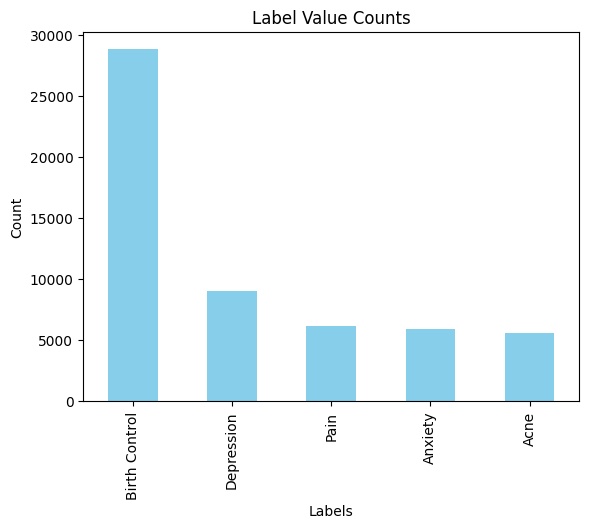

In [16]:
label_counts = df_train['condition'].value_counts()
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Value Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [17]:
# Assuming you want to reduce 'Birth' class by 1800 rows
class_to_reduce = 'Birth Control'
reduction_amount = 10000

# Filter rows with the specified class
birth_rows = df_train[df_train['condition'] == class_to_reduce]

# Check if there are more rows than the reduction amount
if len(birth_rows) > reduction_amount:
    # Randomly select rows to reduce the count to the specified amount
    reduced_birth_rows = birth_rows.sample(len(birth_rows) - reduction_amount, random_state=42)

    # Create a new DataFrame excluding the rows to be reduced
    df_train = df_train[~df_train.index.isin(reduced_birth_rows.index)]

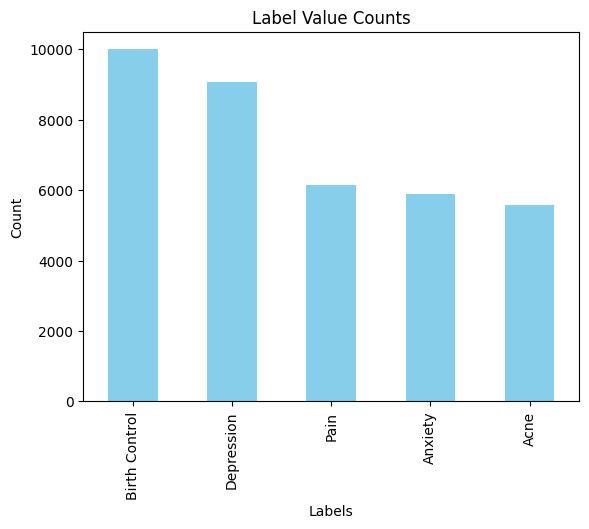

In [18]:
label_counts = df_train['condition'].value_counts()
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Value Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

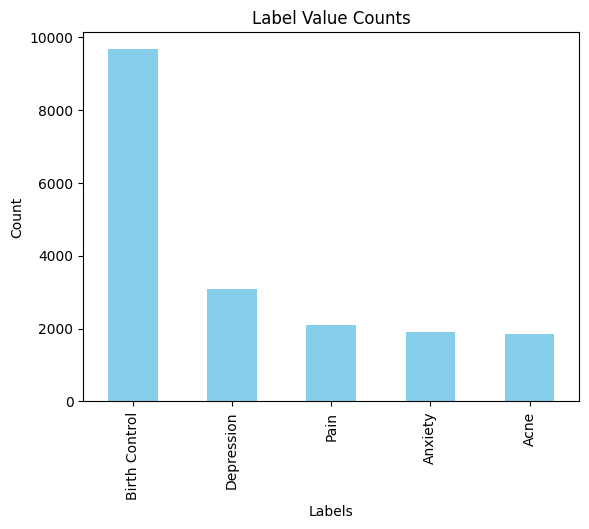

In [19]:
label_counts =df_test['condition'].value_counts()
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Value Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Data Cleaning and Preprocessing

In [20]:
# Remove unwanted tags
def clean_text(text):
    # Remove commas and forward slashes
    text = re.sub(r'[&#039;]', '', text)
    text = re.sub(r'[\']', '', text)
    # Remove HTML tags like '<br />'
    text = re.sub(r'<.*?>', '', text)
    # Remove other unwanted symbols or characters
    text = re.sub(r'[!@#$%^&*()]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text

In [21]:
df_train['review'] = df_train['review'].apply(clean_text)
df_test['review'] = df_test['review'].apply(clean_text)

In [22]:
df_train['condition'].unique(), df_test['condition'].unique()

(array(['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne'],
       dtype=object),
 array(['Depression', 'Birth Control', 'Acne', 'Pain', 'Anxiety'],
       dtype=object))

In [23]:
df_test['review'][0]

'"Ive tried a few antidepressants over the years citalopram, fluoxetine, amitriptyline, but none of those helped with my depression, insomnia amp anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, Ive actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."'

In [24]:
le = LabelEncoder()
df_train['condition'] = le.fit_transform(df_train['condition'])
df_test['condition'] = le.fit_transform(df_test['condition'])

In [25]:
print(df_train['condition'].unique())
print('\n', df_test['condition'].unique())

[2 3 4 1 0]

 [3 2 0 4 1]


In [26]:
train_text, val_text, train_labels, val_labels = train_test_split(df_train['review'], df_train['condition'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df_train['condition'])

In [27]:
print(train_text.shape, val_text.shape, train_labels.shape, val_labels.shape)

(25694,) (11012,) (25694,) (11012,)


In [28]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [29]:
max_seq_len = 512

In [30]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    df_test['review'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [31]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(df_test['condition'].tolist())

In [32]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [33]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [34]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, num_classes=5):  # Set num_classes to 5
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with num_classes output units
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [35]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)

In [36]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 1.31359918200409,
 1: 1.243358335349625,
 2: 0.7341142857142857,
 3: 0.8095148078134846,
 4: 1.194791908858405}

In [38]:
list(class_weights.values())

[1.31359918200409,
 1.243358335349625,
 0.7341142857142857,
 0.8095148078134846,
 1.194791908858405]

In [39]:
# convert class weights to tensor
weights= torch.tensor(list(class_weights.values()),dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 5

In [40]:
epochs = 10

In [41]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        # clear previously calculated gradients
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds


In [42]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [43]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert_saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 10
  Batch    50  of    803.
  Batch   100  of    803.
  Batch   150  of    803.
  Batch   200  of    803.
  Batch   250  of    803.
  Batch   300  of    803.
  Batch   350  of    803.
  Batch   400  of    803.
  Batch   450  of    803.
  Batch   500  of    803.
  Batch   550  of    803.
  Batch   600  of    803.
  Batch   650  of    803.
  Batch   700  of    803.
  Batch   750  of    803.
  Batch   800  of    803.

Evaluating...
  Batch    50  of    345.
  Batch   100  of    345.
  Batch   150  of    345.
  Batch   200  of    345.
  Batch   250  of    345.
  Batch   300  of    345.

Training Loss: 1.257
Validation Loss: 1.101

 Epoch 2 / 10
  Batch    50  of    803.
  Batch   100  of    803.
  Batch   150  of    803.
  Batch   200  of    803.
  Batch   250  of    803.
  Batch   300  of    803.
  Batch   350  of    803.
  Batch   400  of    803.
  Batch   450  of    803.
  Batch   500  of    803.
  Batch   550  of    803.
  Batch   600  of    803.
  Batch   650  of    803.


In [45]:
path = "/kaggle/working/bert_saved_weights.pt"
model.load_state_dict(torch.load(path, map_location=torch.device(device)))

<All keys matched successfully>

In [47]:
import torch

# Set your batch size
batch_size = 32

# Initialize an empty array to store predictions
all_preds = []

# Iterate through the test data in batches
for i in range(0, len(test_seq), batch_size):
    # Get a batch of data
    batch_seq = test_seq[i:i + batch_size].to(device)
    batch_mask = test_mask[i:i + batch_size].to(device)

    # Perform inference on the batch
    with torch.no_grad():
        preds = model(batch_seq, batch_mask)
        preds = preds.detach().cpu().numpy()

    # Append the batch predictions to the results
    all_preds.append(preds)

# Concatenate predictions from all batches
predictions = np.vstack(all_preds)

In [48]:
preds = np.argmax(predictions, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.63      0.82      0.71      1847
           1       0.41      0.65      0.50      1908
           2       0.93      0.88      0.91      9648
           3       0.70      0.35      0.47      3095
           4       0.66      0.79      0.72      2100

    accuracy                           0.75     18598
   macro avg       0.67      0.70      0.66     18598
weighted avg       0.78      0.75      0.75     18598



In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, preds)

array([[1523,   41,  188,   13,   82],
       [  33, 1233,   96,  324,  222],
       [ 654,  187, 8523,  100,  184],
       [  87, 1267,  311, 1081,  349],
       [ 135,  253,   37,   25, 1650]])

In [50]:
from sklearn.metrics import confusion_matrix
import itertools
#plot confusion matrix
def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_mark = np.arange(len(classes))
  plt.xticks(tick_mark, classes, rotation=45)
  plt.yticks(tick_mark, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.axis]
    print("normalized confusion matrix")

  else:
    print("confusion matrix without normalization")
  
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.xlabel("predicted label")
  plt.ylabel("True label")

In [51]:
cm = confusion_matrix(test_y, preds)

In [53]:
df_test['condition'].unique()

array([3, 2, 0, 4, 1])

confusion matrix without normalization


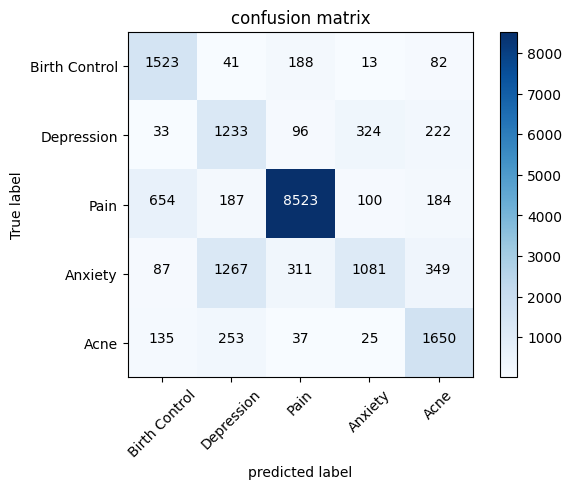

In [55]:
class_names = ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne']
plt_confusion_matrix(cm=cm, classes=class_names, title="confusion matrix", )